## NOTES
- This [LINK](https://drive.google.com/drive/folders/1dCWy614o22cITHaZA0OCvrdM1SyFkRlQ?usp=sharing) contains all the files used in this notebook, such as: **best.pt**, **video.mp4**, **output.mp4**, and **car_plate_OCR.png** that you might use through out this notebook.

- All required files will be downloaded during this notebook and you don't have to download anything locally, but that link is provided in case you want to look at some of the files.

## Install & Imports

In [ ]:
!pip install ultralytics


In [ ]:
!pip install roboflow


In [ ]:
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO, solutions
from IPython.display import Image, display
from IPython import display
from PIL import Image
import cv2
display.clear_output()


from roboflow import Roboflow

# For GPU checkings
import tensorflow as tf


In [ ]:
rf = Roboflow(api_key="api_key")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.87, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to License-Plate-Recognition-1 in yolov8:: 100%|██████████| 20264/20264 [00:05<00:00, 3860.93it/s]


## Dataset exploration

In [ ]:
%cat /content/License-Plate-Recognition-1/data.yaml

names:
- License_Plate
nc: 1
roboflow:
  license: CC BY 4.0
  project: license-plate-recognition-rxg4e
  url: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/1
  version: 1
  workspace: roboflow-universe-projects
test: ../test/images
train: License-Plate-Recognition-1/train/images
val: License-Plate-Recognition-1/valid/images


In [ ]:
dataset.location

'/content/License-Plate-Recognition-1'

### Update `yaml` file
- So it then has the correct path for: train, valid, and test

In [ ]:

def update_yaml_paths(yaml_file_path, correct_path):
    # Load the existing YAML file
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)
    #
    # Update the paths in the dictionary
    if 'test' in data:
        data['test'] = os.path.join(correct_path, "test/images")
    if 'train' in data:
        data['train'] = os.path.join(correct_path, "train/images")
    if 'val' in data:
        data['val'] = os.path.join(correct_path, "valid/images")

    # Save the updated YAML file
    with open(yaml_file_path, 'w') as file:
        yaml.dump(data, file)

yaml_path = "/content/License-Plate-Recognition-1/data.yaml"
update_yaml_paths(yaml_path, "/content/License-Plate-Recognition-1")

In [ ]:
with open(yaml_path, "r") as file:
  data = yaml.safe_load(file)
  TEST_DIR = data['test']
  TRAIN_DIR = data['train']
  VAL_DIR = data['val']

In [ ]:
print(f"Total Training: {len(os.listdir(TRAIN_DIR))} images")
print(f"Total Validation: {len(os.listdir(VAL_DIR))} images")
print(f"Total Testing: {len(os.listdir(TEST_DIR))} images")

Total Training: 7058 images
Total Validation: 2048 images
Total Testing: 1020 images


## GPU checking

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep  1 16:32:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


## Train, validate, and test

### Train

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=30 imgsz=640 batch=32


100% 6.25M/6.25M [00:00<00:00, 337MB/s]
Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/License-Plate-Recognition-1/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

### Validate

In [ ]:
! yolo task=detect mode=val model="/content/runs/detect/train/weights/best.pt" data={dataset.location}/data.yaml

Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/License-Plate-Recognition-1/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% 2048/2048 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [00:22<00:00,  5.66it/s]
                   all       2048       2134      0.981      0.963      0.986      0.726
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Test

In [ ]:
!yolo task=detect mode=predict model="/content/runs/detect/train/weights/best.pt" conf=0.30 source={dataset.location}/test/images

Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1020 /content/License-Plate-Recognition-1/test/images/0002a5b67e5f0909_jpg.rf.c8f81ef986e3e99af6f349c200080453.jpg: 480x640 2 License_Plates, 45.5ms
image 2/1020 /content/License-Plate-Recognition-1/test/images/000812dcf304a8e7_jpg.rf.ba32e6c184b3d974abcced6f7c29af6d.jpg: 576x640 1 License_Plate, 34.1ms
image 3/1020 /content/License-Plate-Recognition-1/test/images/0010f4c10f7ab07e_jpg.rf.1844f6dde3b97ed1c762db933bbacaf3.jpg: 480x640 1 License_Plate, 6.8ms
image 4/1020 /content/License-Plate-Recognition-1/test/images/001cdd25e148cd36_jpg.rf.f6b127a00cc60969152a8a039351ce11.jpg: 480x640 1 License_Plate, 6.1ms
image 5/1020 /content/License-Plate-Recognition-1/test/images/002519f868563098_jpg.rf.29775b804909c1d042ce008c09f033e4.jpg: 448x640 1 License_Plate, 33.6ms
image 6/1020 /content/License-Plate-Recognition-1/te

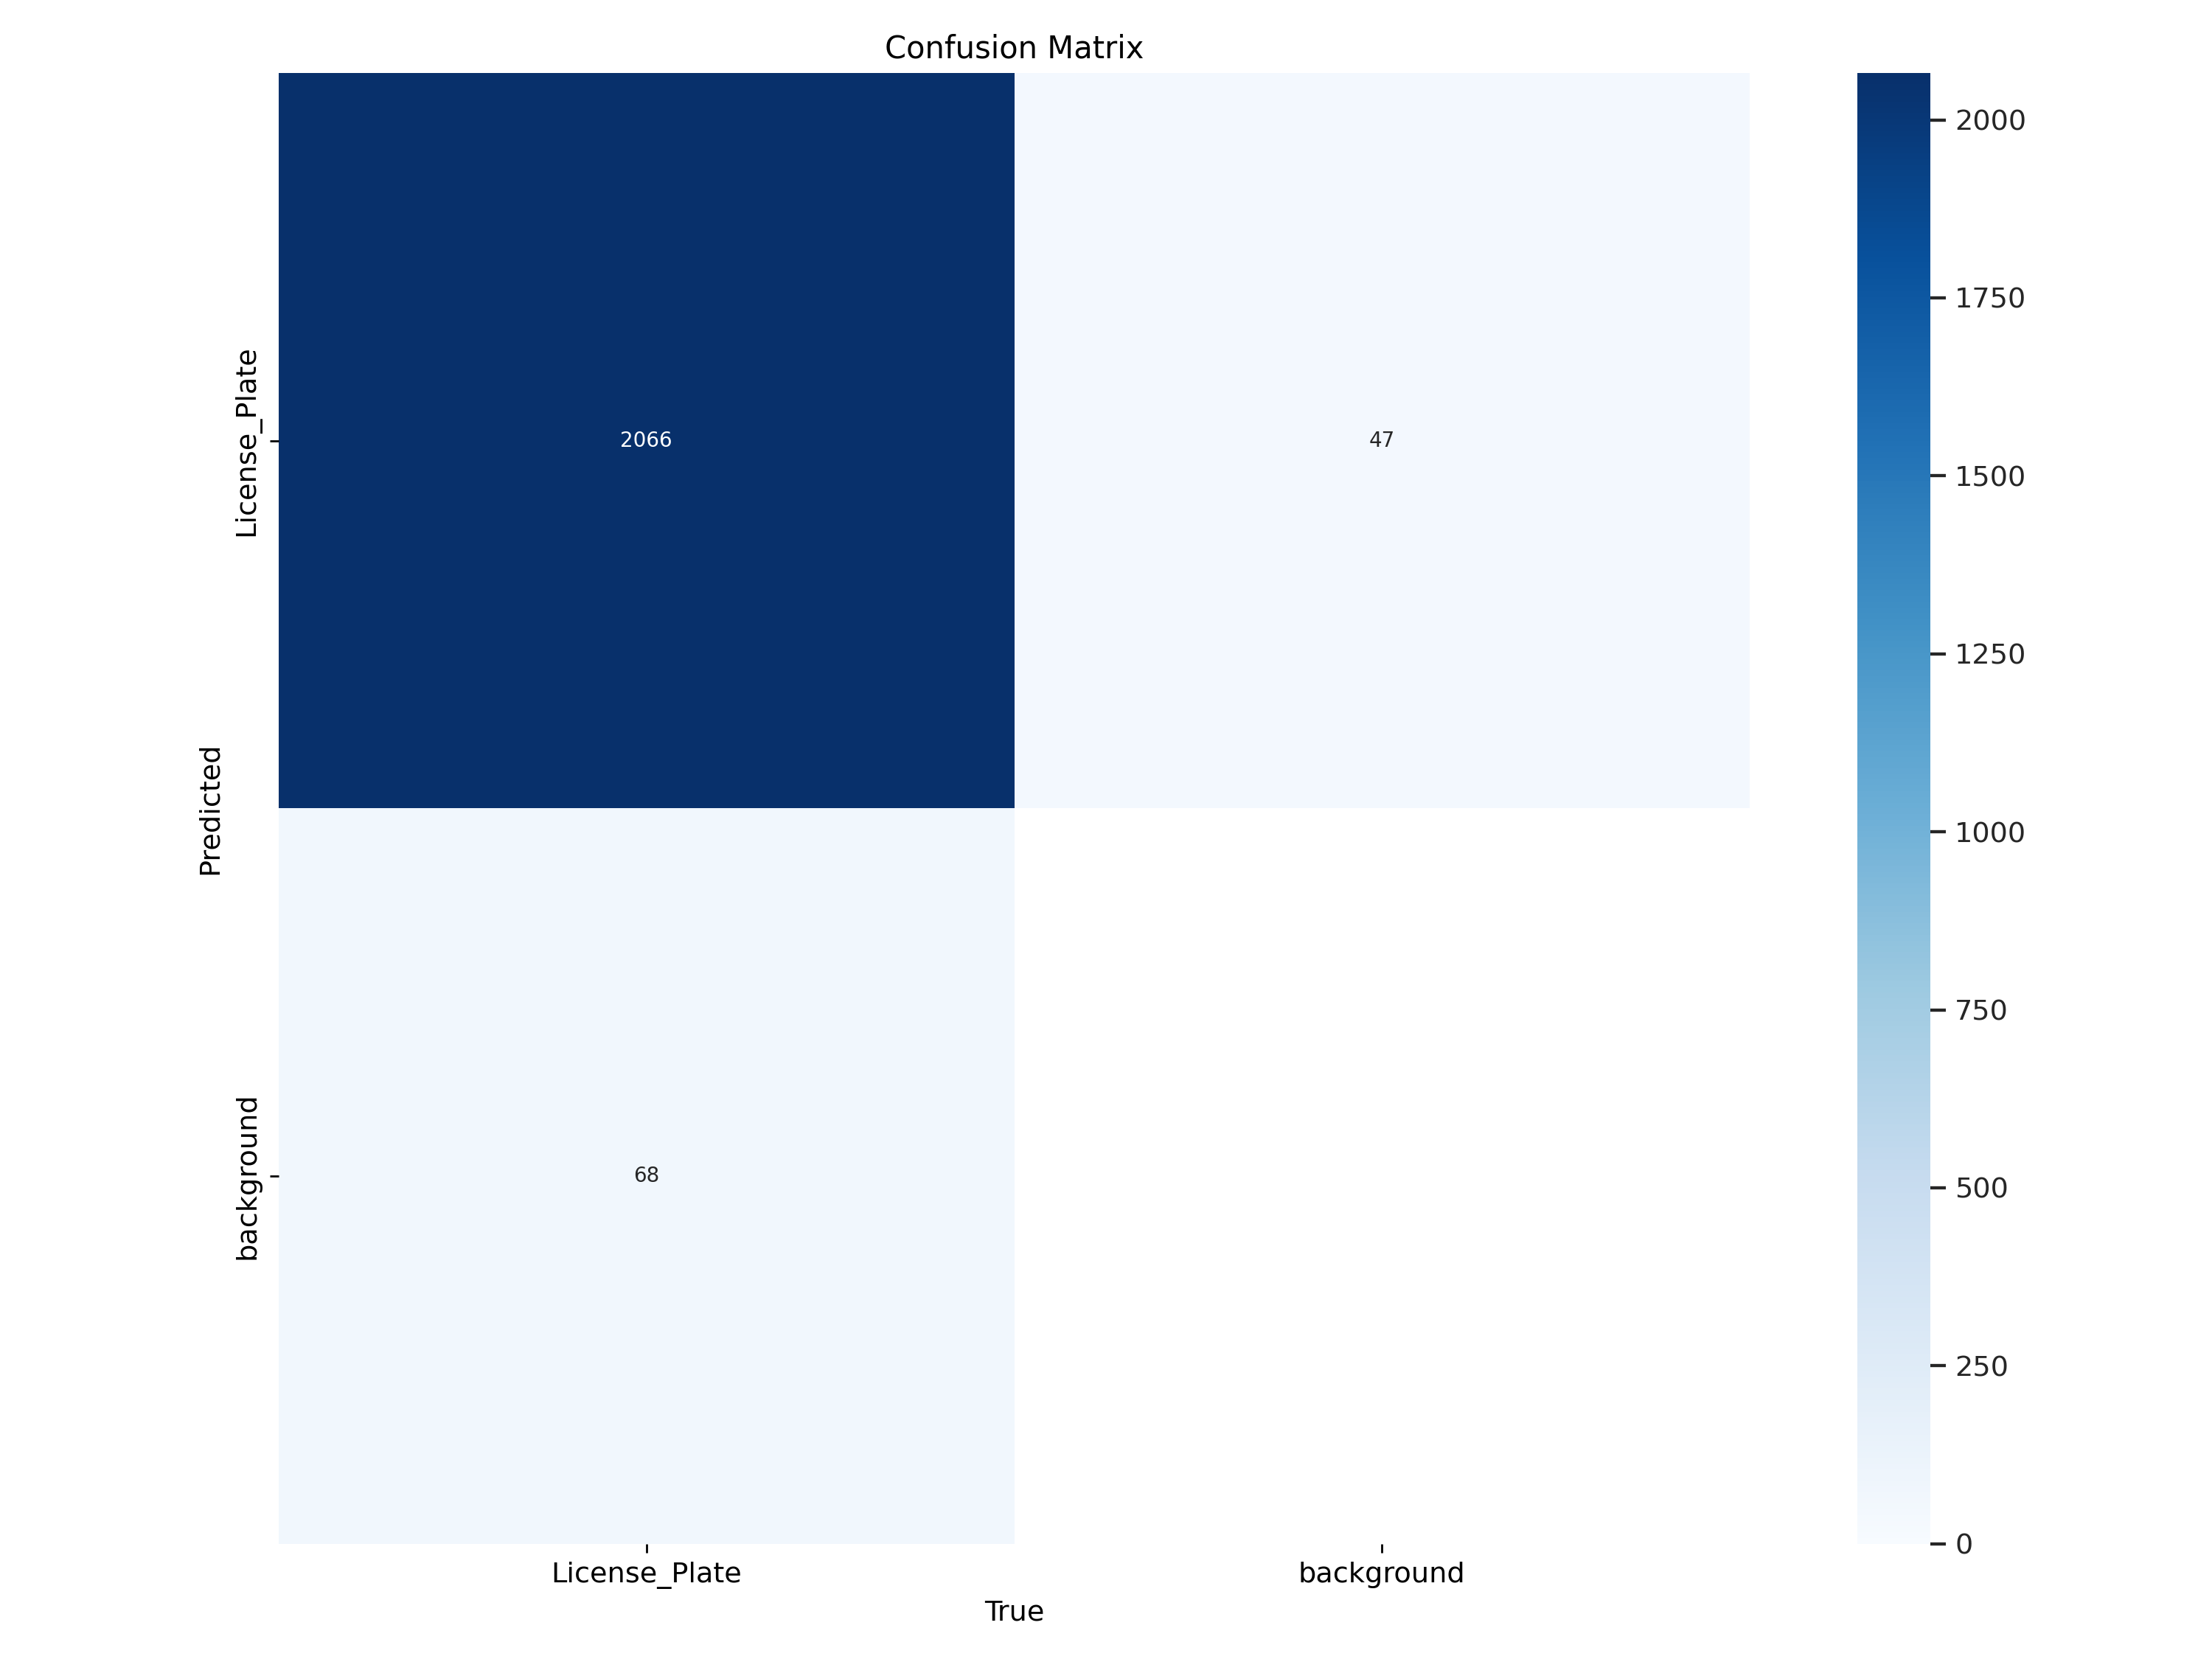

In [ ]:
cm = Image.open("/content/runs/detect/train/confusion_matrix.png")

cm

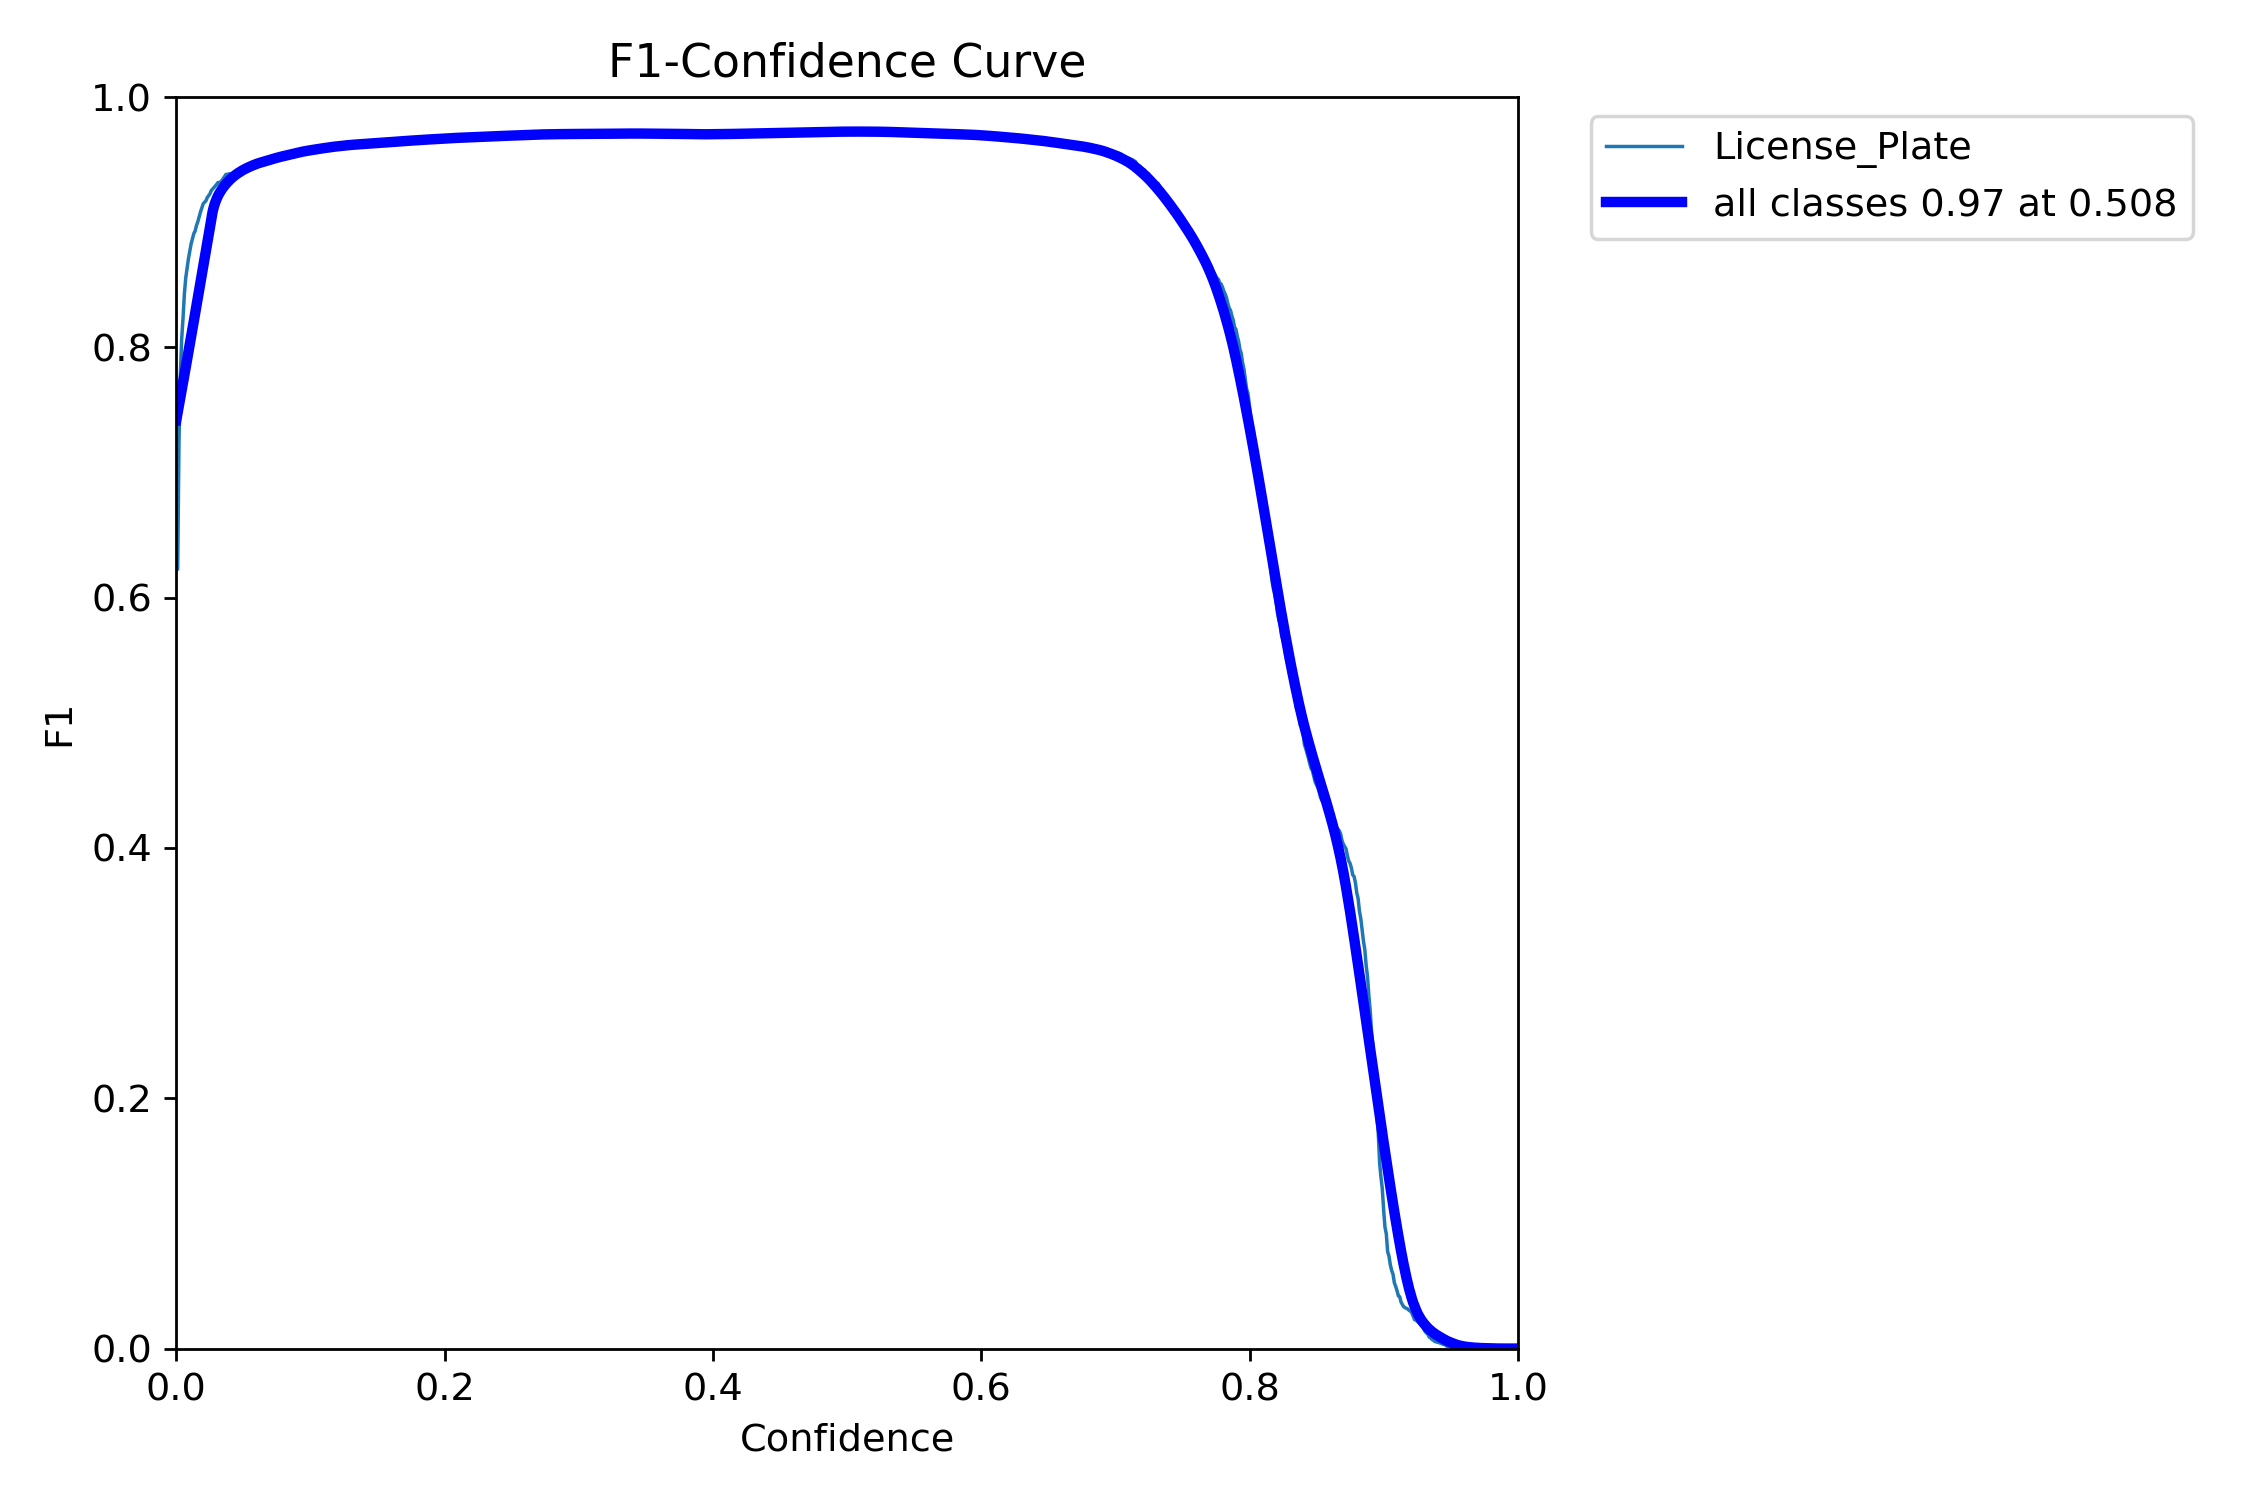

In [ ]:
Image.open("/content/runs/detect/train/F1_curvePR_curveP_curve.png")

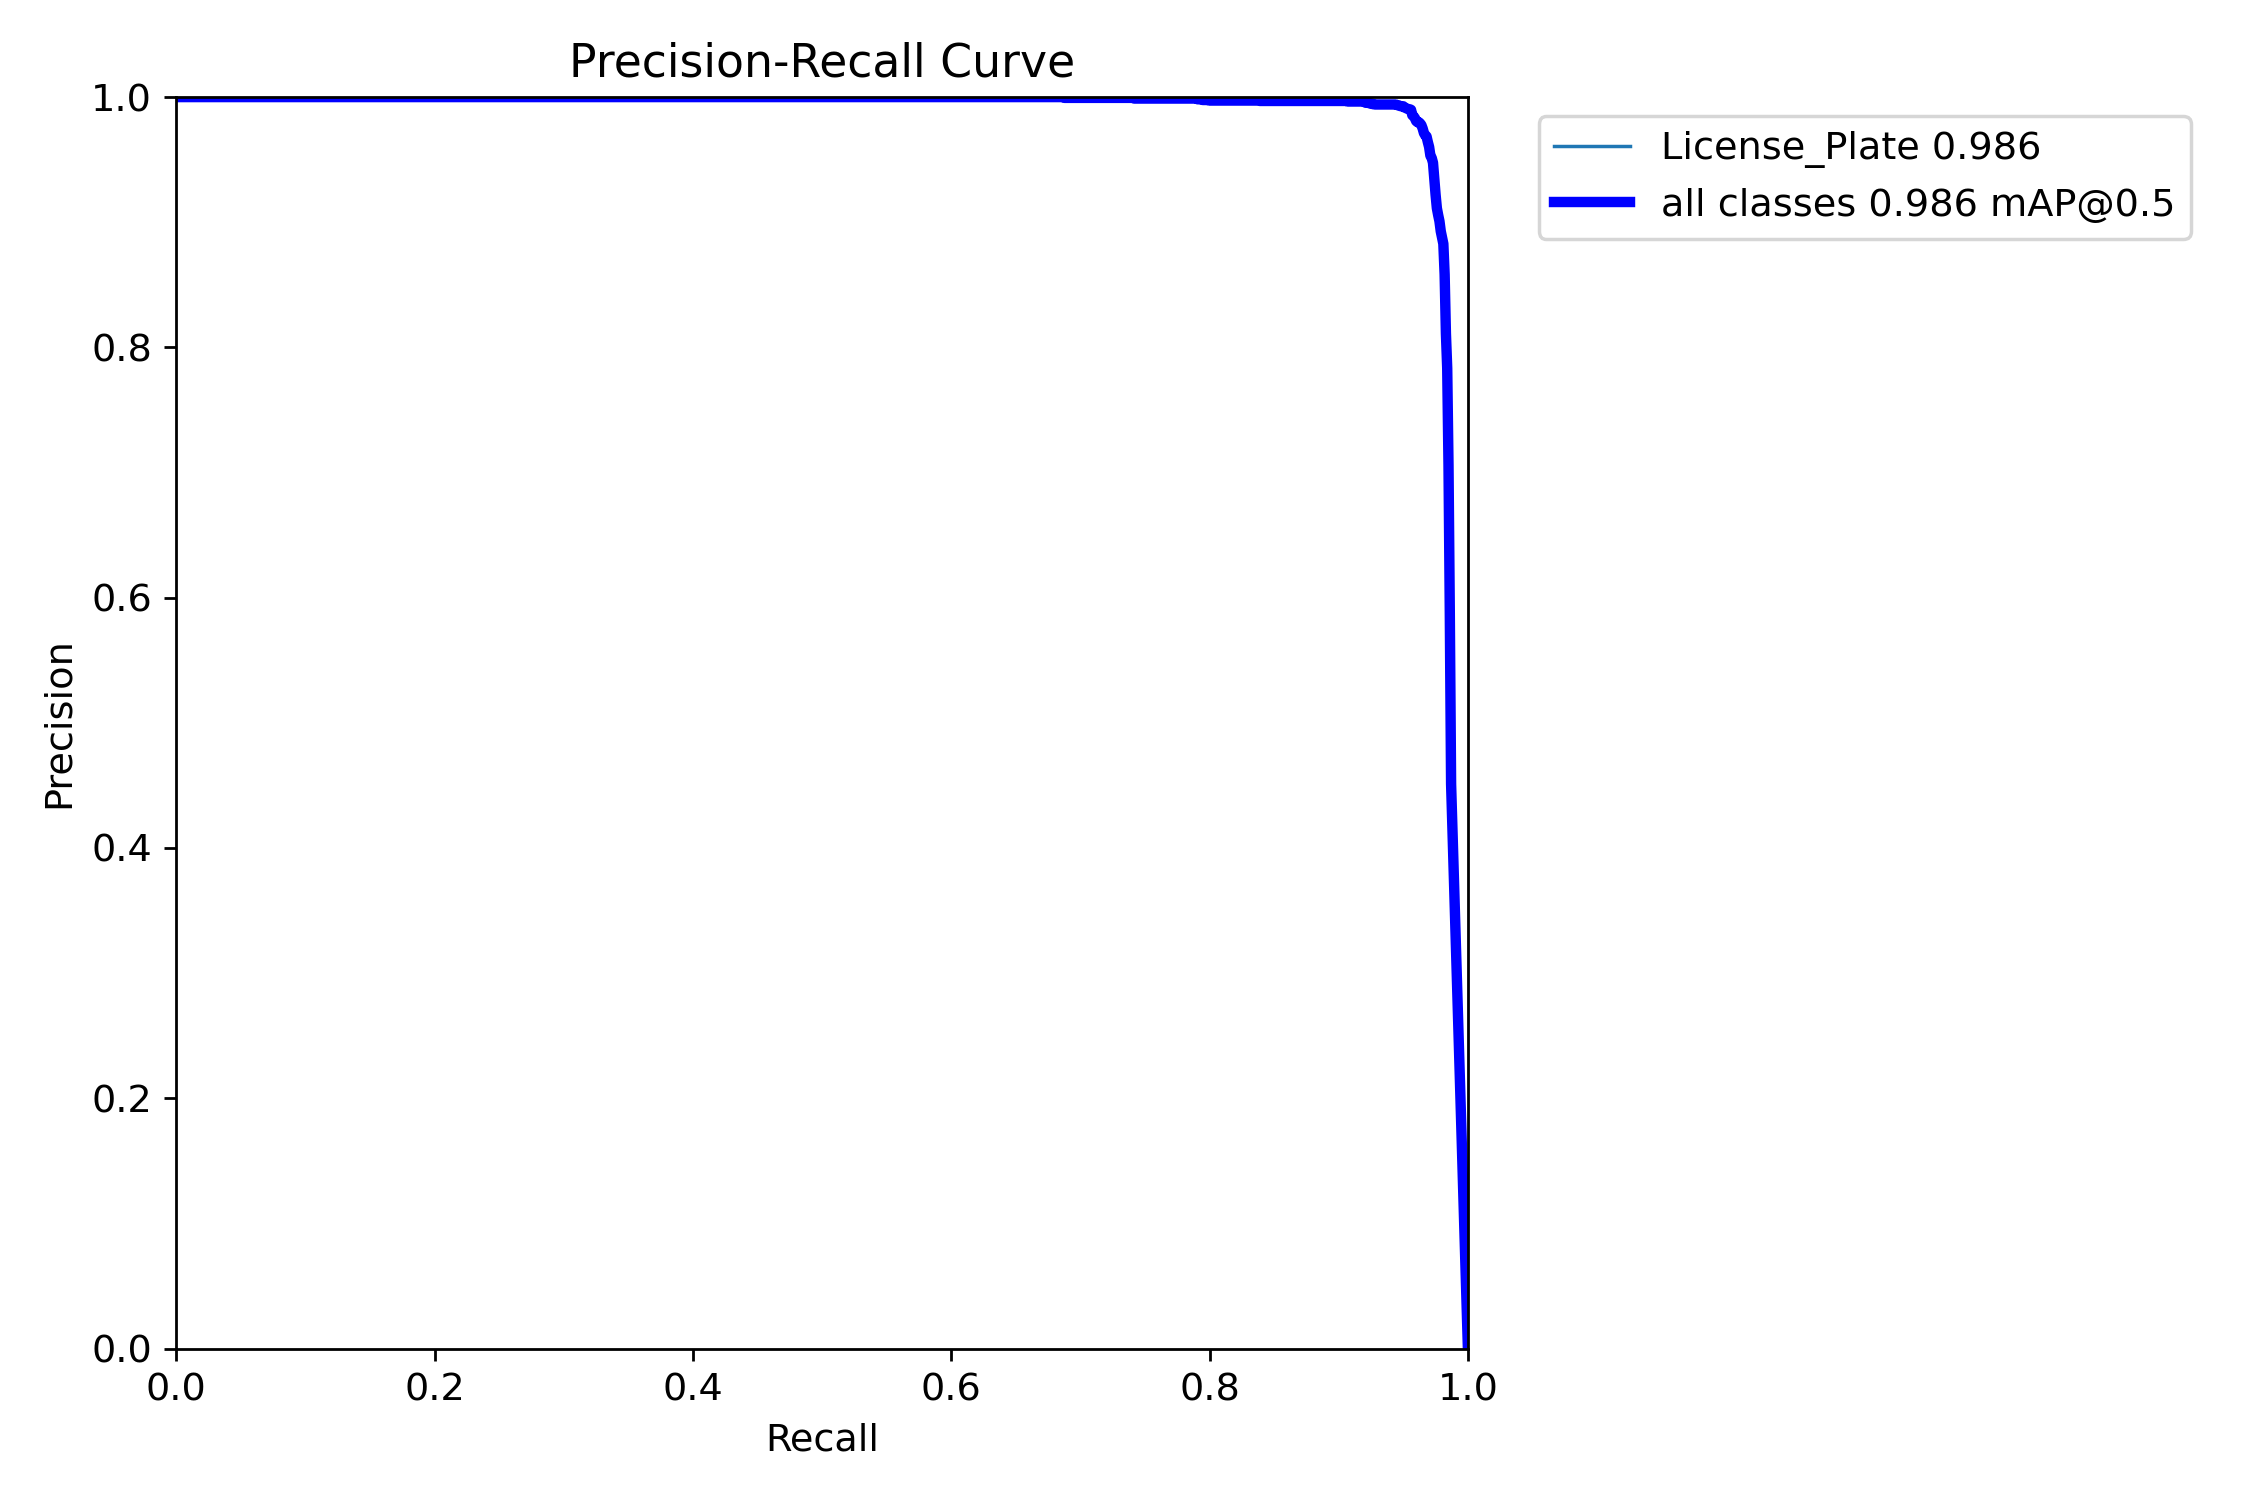

In [ ]:
Image.open("/content/runs/detect/train/PR_curve.png")

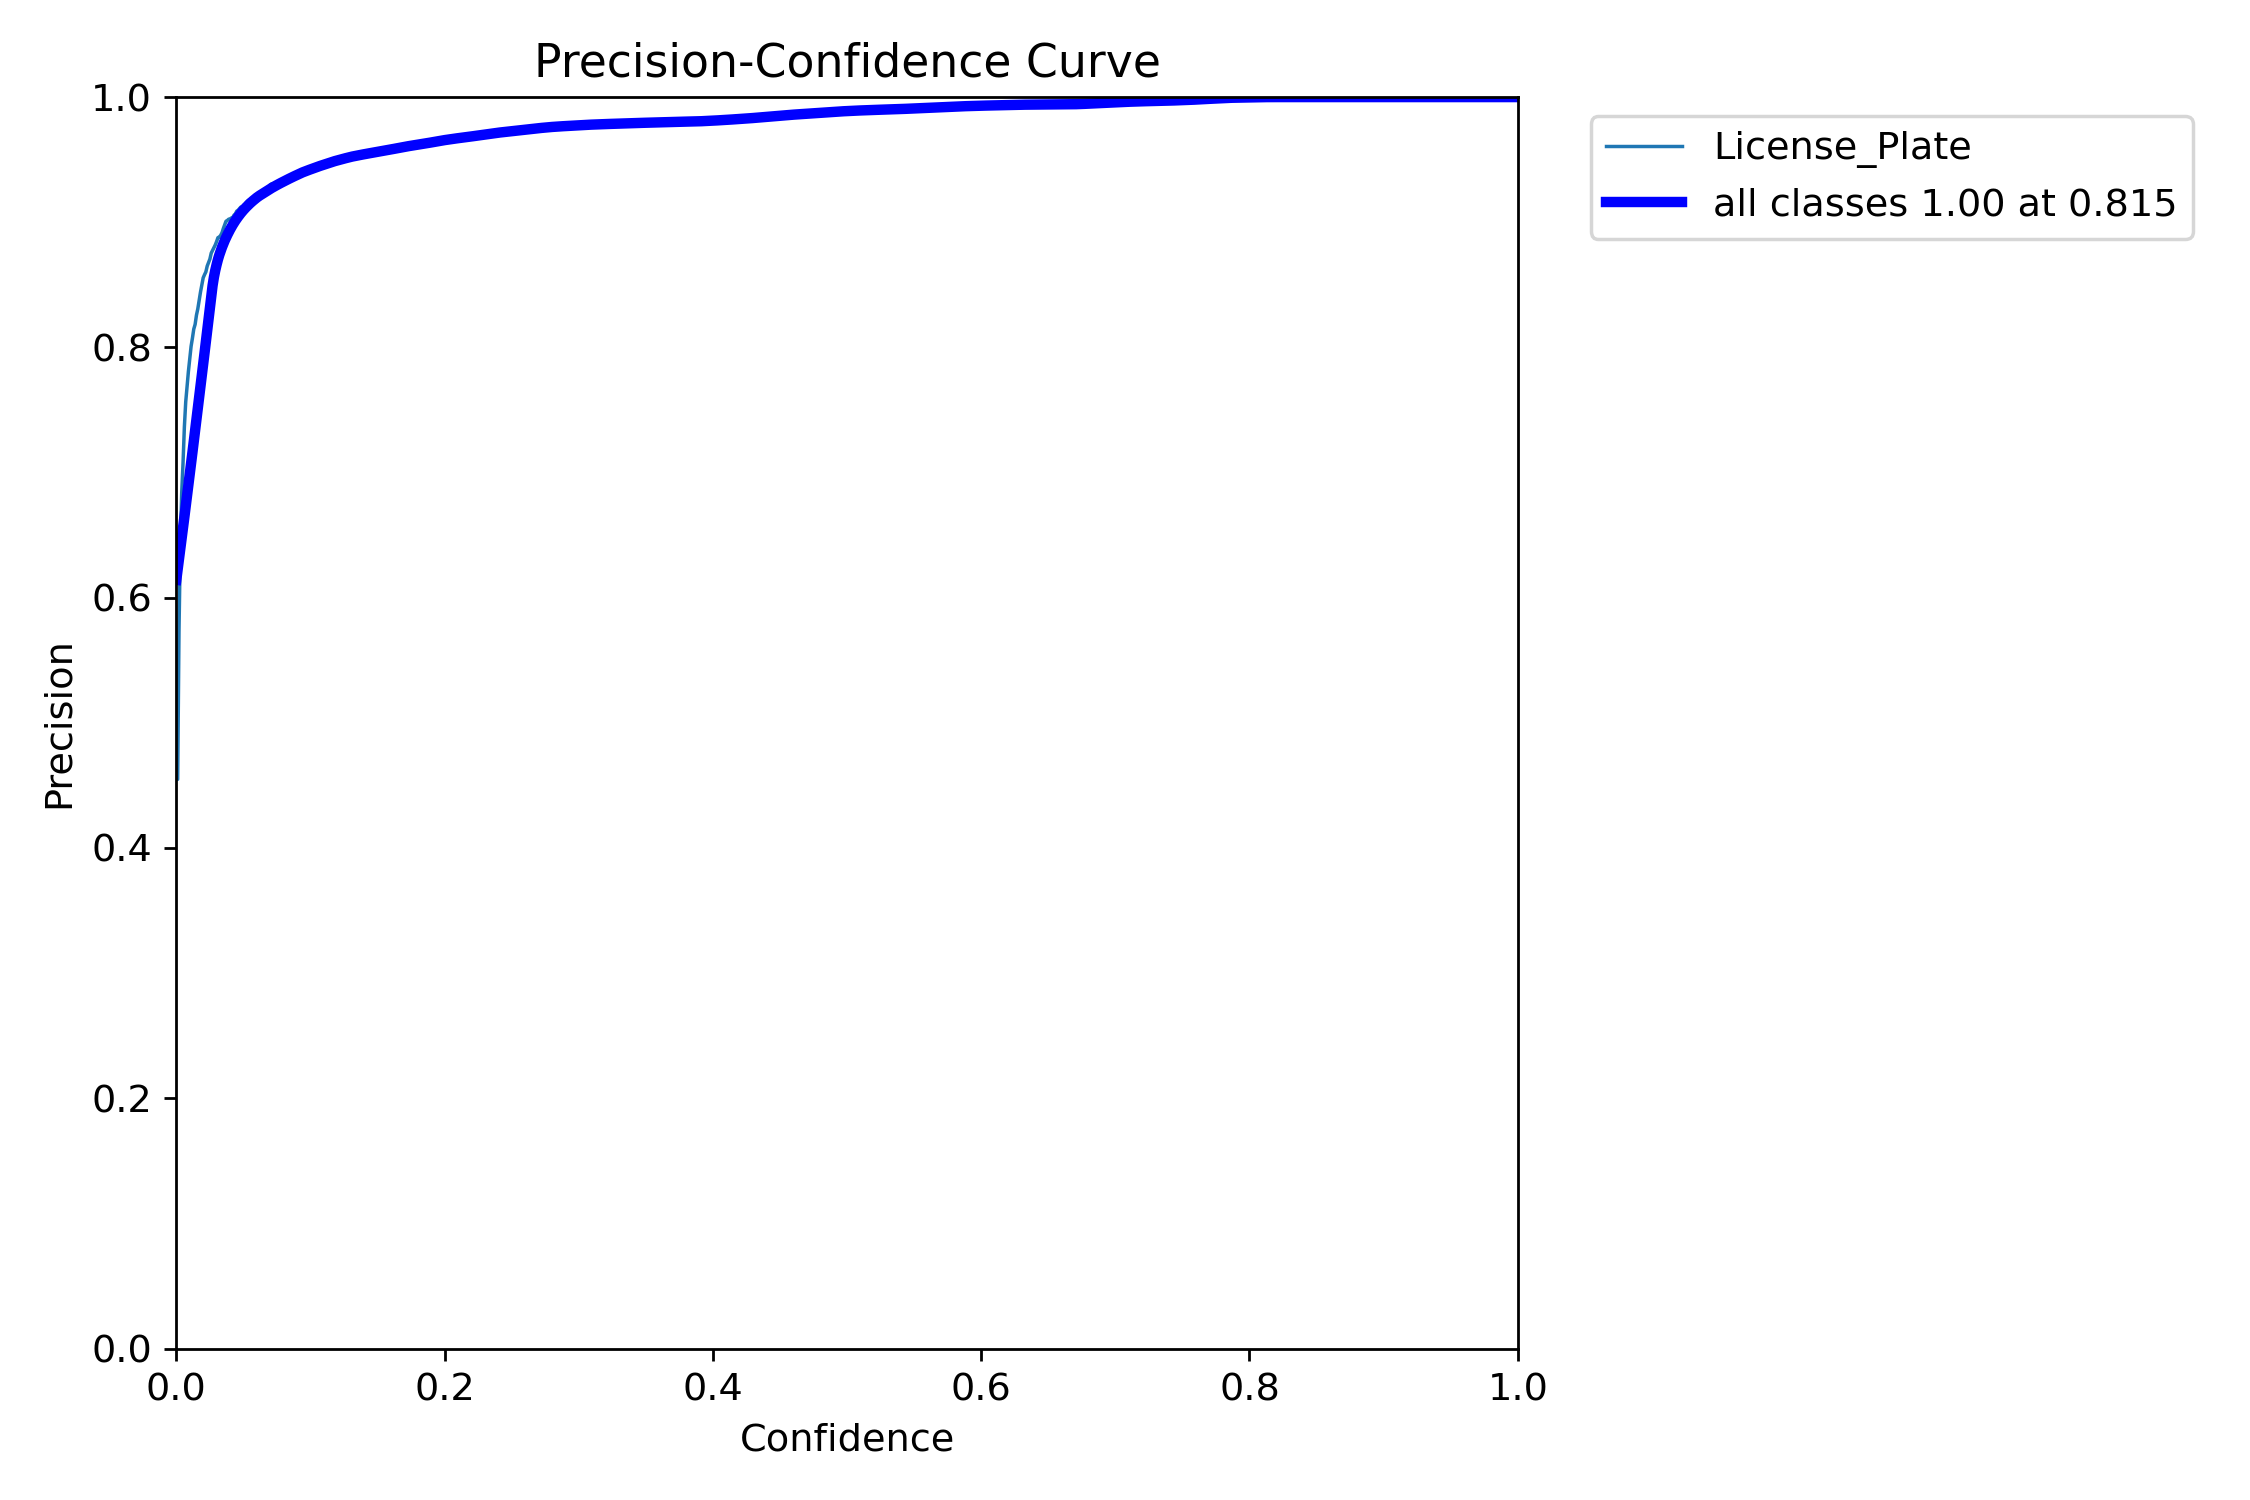

In [ ]:
Image.open("/content/runs/detect/train/P_curve.png")

In [ ]:
def display_curves(directory, dataset_type):
    # Define the image files to display
    curve_files = {
        "R Curve": "R_curve.png",
        "P Curve": "P_curve.png",
        "PR Curve": "PR_curve.png",
        "F1 Curve": "F1_curve.png"
    }

    # Display each curve
    plt.figure(figsize=(12, 8))
    for i, (curve_name, file_name) in enumerate(curve_files.items()):
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            plt.subplot(2, 2, i + 1)
            plt.imshow(img)
            plt.title(f"{curve_name} ({dataset_type})")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


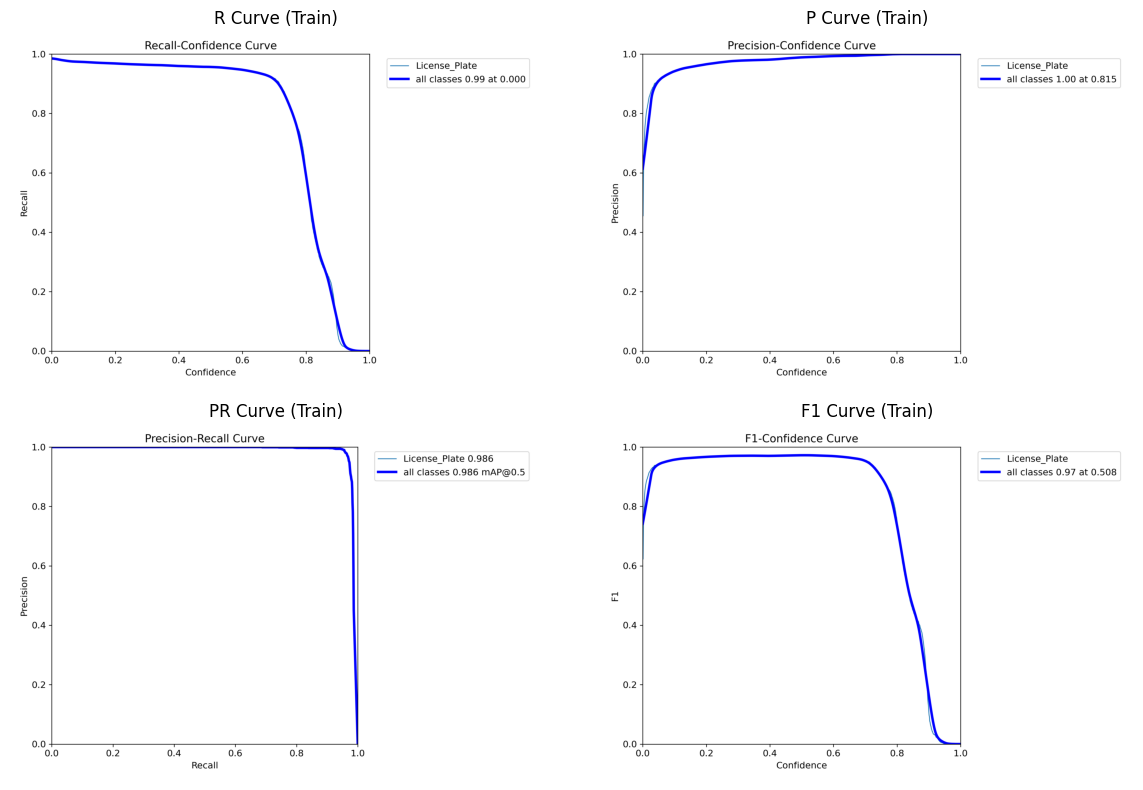

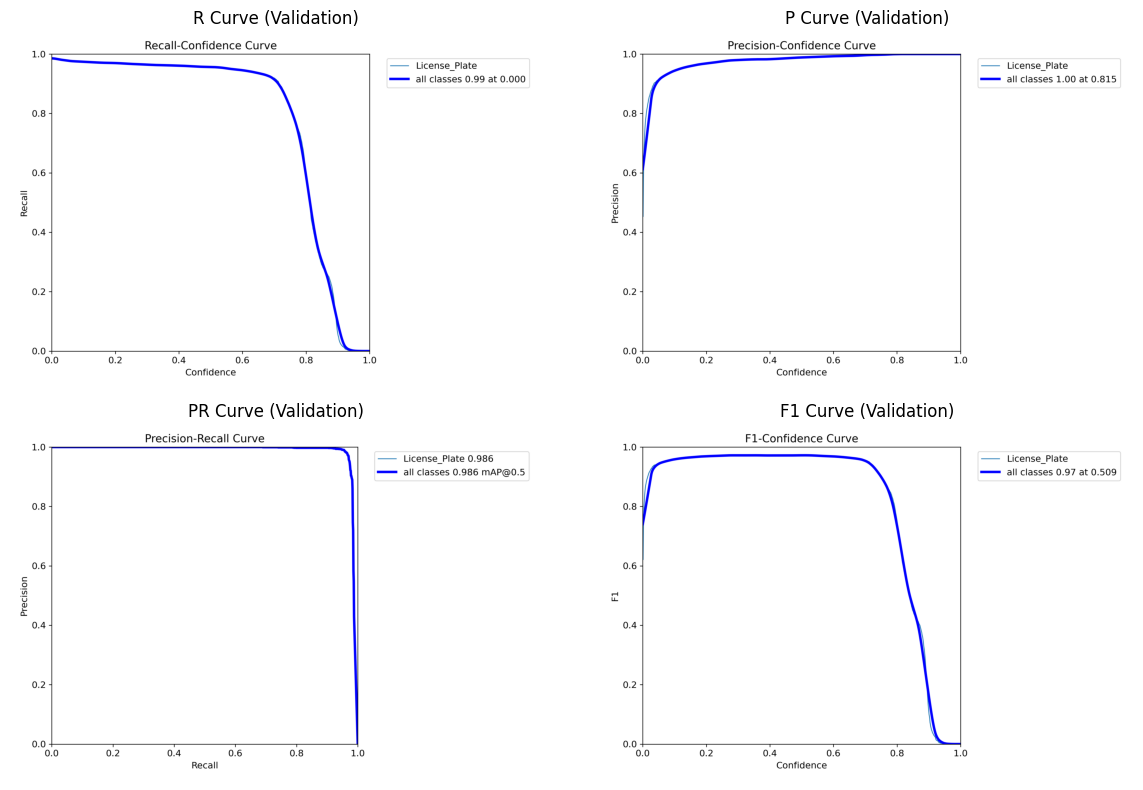

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Display curves for the training dataset
display_curves("/content/runs/detect/train", "Train")

# # Display curves for the validation dataset
display_curves("/content/runs/detect/val", "Validation")

## Export the model

In [ ]:
model.export(format="ncnn")

Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

TorchScript: starting export with torch 2.4.0+cu121...
TorchScript: export success ✅ 2.5s, saved as '/content/runs/detect/train/weights/best.torchscript' (11.9 MB)
requirements: Ultralytics requirement ['ncnn'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 82.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.3s, installed 1 package: ['ncnn']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


NCNN: starting export with NCNN 1.0.20240820...
NCNN: WARNING ⚠️ PNNX not found. Attempting to download binary file from https://github.com/pnnx/pnnx/.
Note PNNX Binary file must be placed in current working directory or in /usr/local/lib/python3.10/dist-packages/ultralytics. See PNNX repo

100%|██████████| 21.4M/21.4M [00:00<00:00, 40.4MB/s]
Unzipping pnnx-20240819-linux.zip to /content/pnnx-20240819-linux...: 100%|██████████| 3/3 [00:00<00:00,  6.85file/s]

NCNN: running '/usr/local/lib/python3.10/dist-packages/ultralytics/pnnx /content/runs/detect/train/weights/best.torchscript ncnnparam=/content/runs/detect/train/weights/best_ncnn_model/model.ncnn.param ncnnbin=/content/runs/detect/train/weights/best_ncnn_model/model.ncnn.bin ncnnpy=/content/runs/detect/train/weights/best_ncnn_model/model_ncnn.py pnnxparam=/content/runs/detect/train/weights/best_ncnn_model/model.pnnx.param pnnxbin=/content/runs/detect/train/weights/best_ncnn_model/model.pnnx.bin pnnxpy=/content/runs/detect/train/weights/best_ncnn_model/model_pnnx.py pnnxonnx=/content/runs/detect/train/weights/best_ncnn_model/model.pnnx.onnx fp16=0 device=cpu inputshape="[1, 3, 640, 640]"'


NCNN: export success ✅ 8.5s, saved as '/content/runs/detect/train/weights/best_ncnn_model' (11.6 MB)

Export complete (13.4s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best_ncnn_model imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best_ncnn_model imgsz=640 data=/content/License-Plate-Recognition-1/data.yaml  
Visualize:       https://netron.app


'/content/runs/detect/train/weights/best_ncnn_model'

## Get the custom model

In [ ]:
# Get the custom model we just trained
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [ ]:
# OR
!gdown "https://drive.google.com/uc?id=12H_EhIcfmNz1oG6SsTY_983tWsamU6x2" -O "best.pt"

model = YOLO("/content/best.pt")

Downloading...
From: https://drive.google.com/uc?id=12H_EhIcfmNz1oG6SsTY_983tWsamU6x2
To: /content/best.pt
100% 6.25M/6.25M [00:00<00:00, 141MB/s]


## Display prediction on a test sample

In [ ]:
test_imgs = []
for i in range(9):
  test_imgs.append(TEST_DIR + "/" + os.listdir(TEST_DIR)[i])

test_imgs

['/content/License-Plate-Recognition-1/test/images/0269b68e1093b0be_jpg.rf.d849090c88004eebda423e5fc2874c19.jpg',
 '/content/License-Plate-Recognition-1/test/images/CarLongPlate488_jpg.rf.81b5b99579c87ac9e2074d903d3b9b9e.jpg',
 '/content/License-Plate-Recognition-1/test/images/xemay897_jpg.rf.7abe359a2ca7a813e231deb97b6bfdab.jpg',
 '/content/License-Plate-Recognition-1/test/images/CarLongPlateGen3297_jpg.rf.578b545df41de2984c03dfe7e9b837f3.jpg',
 '/content/License-Plate-Recognition-1/test/images/xemay459_jpg.rf.1893780816538c2c53237e5d50aa4c82.jpg',
 '/content/License-Plate-Recognition-1/test/images/CarLongPlateGen318_jpg.rf.cf1fd8e8e8879cdb9f49c355078df57e.jpg',
 '/content/License-Plate-Recognition-1/test/images/CarLongPlateGen1747_jpg.rf.229c99700aedcfe0d9bf0bd0179fa6b4.jpg',
 '/content/License-Plate-Recognition-1/test/images/00a7d31c6cc6b7f3_jpg.rf.641695200cda83be76f64c5402215f27.jpg',
 '/content/License-Plate-Recognition-1/test/images/xemayBigPlate48_jpg.rf.b0c2b4d95f23c4401ff5de6


image 1/1 /content/License-Plate-Recognition-1/test/images/0269b68e1093b0be_jpg.rf.d849090c88004eebda423e5fc2874c19.jpg: 448x640 1 License_Plate, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/License-Plate-Recognition-1/test/images/CarLongPlate488_jpg.rf.81b5b99579c87ac9e2074d903d3b9b9e.jpg: 416x640 1 License_Plate, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/License-Plate-Recognition-1/test/images/xemay897_jpg.rf.7abe359a2ca7a813e231deb97b6bfdab.jpg: 416x640 1 License_Plate, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/License-Plate-Recognition-1/test/images/CarLongPlateGen3297_jpg.rf.578b545df41de2984c03dfe7e9b837f3.jpg: 416x640 1 License_Plate, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

image 1

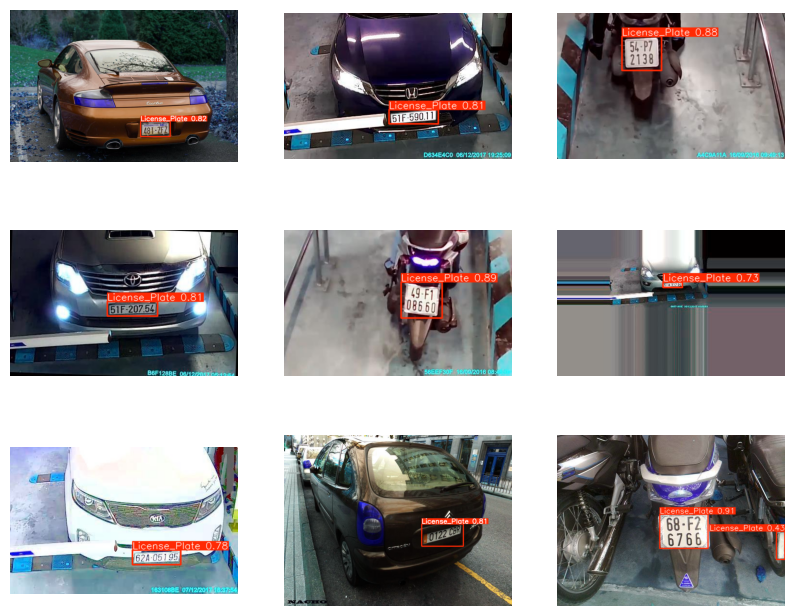

In [ ]:
_, ax = plt.subplots(3, 3, figsize=(10, 8))

for i, img_path in enumerate(test_imgs):

    result = model.predict(img_path)
    result = result[0].plot()

    ax.flat[i].axis('off')

    ax.flat[i].imshow(result)

plt.show()

## Test on a video

### Download the video

In [ ]:
!gdown "https://drive.google.com/uc?id=1iuKMuyeE6iuUv7UjZB1355wBz1vDuNui" -O "video.MP4"

Downloading...
From (original): https://drive.google.com/uc?id=1iuKMuyeE6iuUv7UjZB1355wBz1vDuNui
From (redirected): https://drive.google.com/uc?id=1iuKMuyeE6iuUv7UjZB1355wBz1vDuNui&confirm=t&uuid=af6bce79-2011-46d8-99f8-fbd9dfbef3f3
To: /content/video.MP4
100% 210M/210M [00:09<00:00, 21.3MB/s]


In [ ]:

cap = cv2.VideoCapture("/content/video.MP4")

# Video information: Width, Height, and frame per second
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))


In [ ]:
print(w, h, fps)

2592 1944 30


In [ ]:
# Create the output file which will be the video with car plates being detected and localized with bouding box
output_vid = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

In [ ]:

while True:
  success, img = cap.read()

  if not success:
    print("[NOT SUCCESS] No frames left or there is something wrong")
    break

  img = model.predict(img)
  annotated_frame = img[0].plot()

  output_vid.write(img)

cap.release()
output_vid.release()
cv2.destroyAllWindows()



Streaming output truncated to the last 5000 lines.
Speed: 3.1ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 License_Plate, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 License_Plate, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.7ms
Speed: 2.7ms preprocess, 7.7ms i

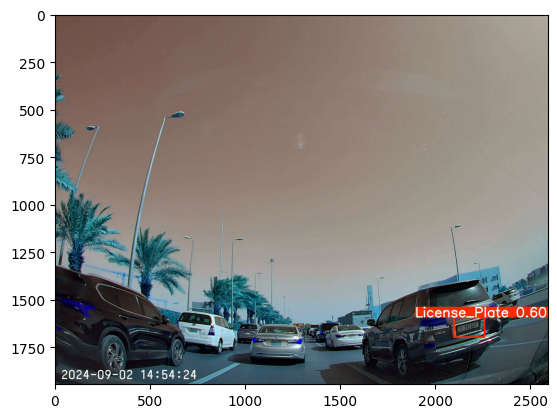

In [ ]:
cap_output = cv2.VideoCapture("/content/output.mp4")

success, img = cap_output.read()

plt.imshow(img)


## Recognize the plate with kerasOCR and Easyocr

### Helper functions

In [ ]:
# Grayscale conversion
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Noise removal
def remove_noise(image):
    return cv2.medianBlur(image, 5)


# Sharpening
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])  # Sharpening kernel
    return cv2.filter2D(image, -1, kernel)


# Binarization
def binarize_image(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 19, 2)





### Get the image

In [ ]:
!gdown "https://drive.google.com/uc?id=1P-BgTofYwlLaFXNTJtTZDeXPvXILtD1d" -O "car_plate_OCR.png"

Downloading...
From: https://drive.google.com/uc?id=1P-BgTofYwlLaFXNTJtTZDeXPvXILtD1d
To: /content/car_plate_OCR.png
100% 1.11M/1.11M [00:00<00:00, 113MB/s]


(-0.5, 1215.5, 730.5, -0.5)

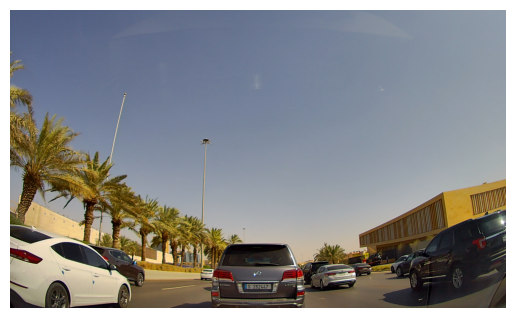

In [ ]:
img = cv2.imread("/content/car_plate_OCR.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

### Zoom in to make the plate more obvious


0: 416x640 1 License_Plate, 80.6ms
Speed: 3.8ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


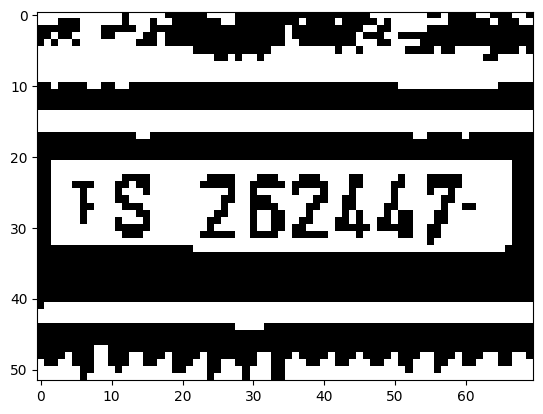

In [ ]:
predict = model.predict(img)

xmin, ymin, xmax, ymax =  [int(x) for x in predict[0].boxes.xyxy[0]]

processed_image = get_grayscale(img)

processed_image = binarize_image(processed_image)

zoomed_img = processed_image[ymin - 15 :ymax + 15 , xmin :xmax]


# Convert back to RGB for OCR
zoomed_img = cv2.cvtColor(zoomed_img, cv2.COLOR_GRAY2RGB)

zoomed_img = sharpen_image(zoomed_img)

plt.imshow(zoomed_img)

### KerasOCR

In [ ]:

# !pip install keras-ocr

# Warning! Don't run this code unless you had an error when creating a pipeline for OCR using KerasOCR in the next code cell
!pip install tensorflow==2.9.1 keras==2.9.0
# After runnig this code you will have to restart the session and import libraries again


In [ ]:

import keras_ocr

# Create a pipeline for OCR using KerasOCR
pipeline = keras_ocr.pipeline.Pipeline()


image = keras_ocr.tools.read(zoomed_img)


# KerasOCR requires the image to be passed as a list, even if you're working with a single image
images = [image]

# Perform OCR on the image
prediction_groups = pipeline.recognize(images)

# Print the recognized text
for predictions in prediction_groups:
    for prediction in predictions:
        print(prediction[0])


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
ls
262lt


In [ ]:
boxes = []
for box in prediction_groups[0]:
  boxes.append(box[1])

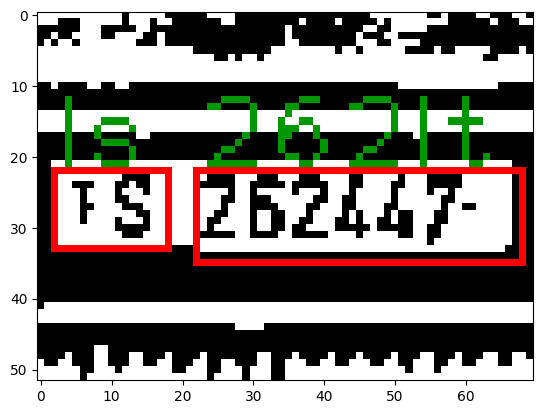

In [ ]:
# You can use this "commented" code to display the annotaions around the car plate
# But the annotation thickness is too big which led to almost covering the plate
# So I used different function which allows me to define the thickness level

# ---------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(12, 12))
# keras_ocr.tools.drawAnnotations(
#     image=images[0], predictions=prediction_groups[0], ax=ax,
#     )


# plt.title("Image with KerasOCR Annotations")
# plt.axis('off')
# plt.show()
# ---------------------------------------------------------------------


annotated_plate = keras_ocr.tools.drawBoxes(image, boxes, color=(255, 0, 0),
                               thickness=1, boxes_format='boxes')

for predict in prediction_groups[0]:
    # x and y coordinates
    x = int(predict[1][0][0])
    y = int(predict[1][0][1])

    cv2.putText(
        annotated_plate,
        text=predict[0],
        org=(x, y),
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1,
        color=(0, 150, 0),
        thickness=1,

    )

plt.imshow(annotated_plate)


- The result is not even close to the real **(ls 262lt != s 626447)**.
- Next, we will use easyOCR to see whether it will get a better result or not

### easyocr

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 17.7 MB/s eta 0:00:00


In [ ]:
import easyocr
reader = easyocr.Reader(['en'])  #  'en' for English language

result = reader.readtext(processed_image)c

print (result)

[([[575, 673], [639, 673], [639, 687], [575, 687]], '1S 262447', 0.7108527758988117)]


In [ ]:
for detection in result:
  print(detection[1])

1S 262447


- Well, this result is almost the same as the real one:
  - **(REAL:S 262447:** and **RESULT:1S 262447)**

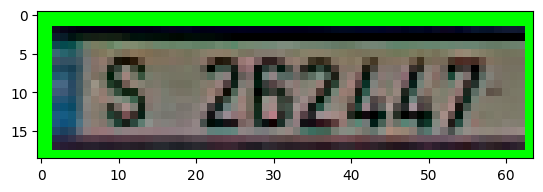

In [ ]:
for detection in result:
    bounding_box = detection[0]

    xmin,ymin = tuple([int(coord) for coord in bounding_box[0]])
    xmax, ymax = tuple([int(coord) for coord in bounding_box[2]])


    cv2.rectangle(img, (xmin, ymin -5), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(img[ymin - 5 :ymax , xmin :xmax])

## FlaskAPI [NOT YET DONE]

In [ ]:
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
from flask import Flask, request, jsonify, send_file
import cv2
import numpy as np
from io import BytesIO
from PIL import Image


ngrok_token = 'SECRET'
port = 5000
ngrok.set_auth_token(ngrok_token)

app = Flask(__name__)




@app.route("/")
def root():
  return "Welcome to Car license plate detection"


@app.route('/upload', methods=['POST'])
def upload_image():
    # Check if an image file is in the POST request
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request'}), 400

    file = request.files['file']

    # If the user does not select a file
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    # Read the image via OpenCV or PIL
    if file:
        # Option 1: Using OpenCV
        # Convert string data to numpy array
        image_bytes = np.fromstring(file.read(), np.uint8)
        # Convert numpy array to image
        img = cv2.imdecode(image_bytes, cv2.IMREAD_COLOR)

        # Option 2: Using PIL (if needed)
        # img = Image.open(io.BytesIO(file.read()))

        # Now, `img` contains the image and you can process it as needed
        # For example, convert to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Encode image to PNG
        is_success, buffer = cv2.imencode(".png", processed_image)
        if not is_success:
            return jsonify({'error': 'Failed to encode image'}), 500

        # Convert buffer to bytes
        io_buf = BytesIO(buffer)

        # Send the processed image as a response
        return send_file(io_buf, mimetype='image/png', as_attachment=True, download_name='processed_image.png')

        return jsonify({'message': 'Image received and processed'}), 200




if __name__ == "__main__":
  try:
    public_url = ngrok.connect(port).public_url
    print(public_url)
    app.run(port=port)
  finally:
    ngrok.disconnect(public_url=public_url)
